# Introduction

### We are going to find CLTV for a E-commerce company data. We'll use BG-NBD & Gamma-Gamma Methods for predictive CLTV

# Importing necessary libraries and settings

In [1]:
!pip install lifetimes

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import squarify
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.width", 1000)
pd.set_option('display.float_format', lambda x: '%.8f' % x)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.6 MB/s eta 0:00:00
/kaggle/input/ecommerce-data/data.csv


# Loading and Understanding Data

In [2]:
df_ = pd.read_csv(r"/kaggle/input/ecommerce-data/data.csv", encoding= 'unicode_escape')
df = df_.copy()

def check_df(dataframe):
    print("##################### First 10 Observations #####################")
    print(dataframe.head(10))
    print("##################### Column names #####################")
    print(df.info())
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Types #####################")
    print(dataframe.dtypes)
check_df(df)

##################### First 10 Observations #####################
  InvoiceNo StockCode                          Description  Quantity     InvoiceDate  UnitPrice     CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26 2.55000000 17850.00000000  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6  12/1/2010 8:26 3.39000000 17850.00000000  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26 2.75000000 17850.00000000  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26 3.39000000 17850.00000000  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/2010 8:26 3.39000000 17850.00000000  United Kingdom
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2  12/1/2010 8:26 7.65000000 17850.00000000  United Kingdom
6    536365     21730    GLASS STAR FROSTED T

### Data Preparation

In [3]:
df.dropna(inplace=True)
df = df[~df["InvoiceNo"].str.contains("C", na=False)] # To get rid of cancelled orders
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397884.00000000,12.98823778,179.33177496,1.00000000,2.00000000,6.00000000,12.00000000,80995.00000000
UnitPrice,397884.00000000,3.11648776,22.09787663,0.00100000,1.25000000,1.95000000,3.75000000,8142.75000000
CustomerID,397884.00000000,15294.42345256,1713.14156044,12346.00000000,13969.00000000,15159.00000000,16795.00000000,18287.00000000


We are removing outliers to make our models work more accurately

In [4]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [5]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "UnitPrice")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397884.00000000,8.31721808,8.09723371,1.00000000,2.00000000,6.00000000,12.00000000,27.00000000
UnitPrice,397884.00000000,2.59815691,2.10307575,0.00100000,1.25000000,1.95000000,3.75000000,7.50000000
CustomerID,397884.00000000,15294.42345256,1713.14156044,12346.00000000,13969.00000000,15159.00000000,16795.00000000,18287.00000000


In [6]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55000000,17850.00000000,United Kingdom,15.30000000
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39000000,17850.00000000,United Kingdom,20.34000000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75000000,17850.00000000,United Kingdom,22.00000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39000000,17850.00000000,United Kingdom,20.34000000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39000000,17850.00000000,United Kingdom,20.34000000


In [7]:
df["InvoiceDate"] = df["InvoiceDate"].apply(pd.to_datetime)

In [8]:

df.InvoiceDate.max() #'9/9/2011 9:52'
today_date = dt.datetime(2011, 12, 11)



# Calculating CLTV

* ### recency: Time elapsed since the last purchase. Weekly. (per user)
* ### T: Age of the customer. Weekly. (how long ago was the first purchase made from the analysis date)
* ### frequency: Total number of repeated purchases. (frequency > 1)
* ### monetary: Average earnings per purchase per customer."
By calculating metrics above, a new dataframe is created called cltv_df which is going to be used for BG-NBD and Gamma-Gamma Models.

In [9]:
cltv_df = df.groupby('CustomerID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'InvoiceNo': lambda InvoiceNo: InvoiceNo.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346.00000000,0,326,1,28.08000000
12347.00000000,365,368,7,3877.44000000
12348.00000000,282,359,4,557.57000000
12349.00000000,0,19,1,1336.65000000
12350.00000000,0,311,1,301.90000000


In [10]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"] # To calculate average monetary

cltv_df = cltv_df[(cltv_df['frequency'] > 1)] # To get rid of values that are equal to 0
# cltv_df = cltv_df[(cltv_df['recency'] > 1)]
cltv_df["recency"] = cltv_df["recency"] / 7  # converting days to weeks

cltv_df["T"] = cltv_df["T"] / 7 # converting days to weeks

cltv_df.head()
check_df(cltv_df)

##################### First 10 Observations #####################
                   recency           T  frequency      monetary
CustomerID                                                     
12347.00000000 52.14285714 52.57142857          7  553.92000000
12348.00000000 40.28571429 51.28571429          4  139.39250000
12352.00000000 37.14285714 42.42857143          8  175.11750000
12356.00000000 43.14285714 46.57142857          3  694.49666667
12358.00000000 21.28571429 21.57142857          2  481.87500000
12359.00000000 39.14285714 47.42857143          4 1152.90750000
12360.00000000 21.14285714 28.71428571          3  722.73666667
12362.00000000 41.71428571 42.28571429         10  478.82800000
12363.00000000 18.85714286 34.71428571          2  272.17500000
12364.00000000 14.85714286 16.14285714          4  298.71000000
##################### Column names #####################
<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):

### BG/NBD model
with this model we are going to calculate expected number of purchases in a specified time period

In [11]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.18231589,0.07561869,2.03410325,2.33052852
alpha,11.40788437,0.46062226,10.50506474,12.31070400
a,0.11857810,0.01268537,0.09371478,0.14344143
b,2.49082634,0.22930654,2.04138551,2.94026716


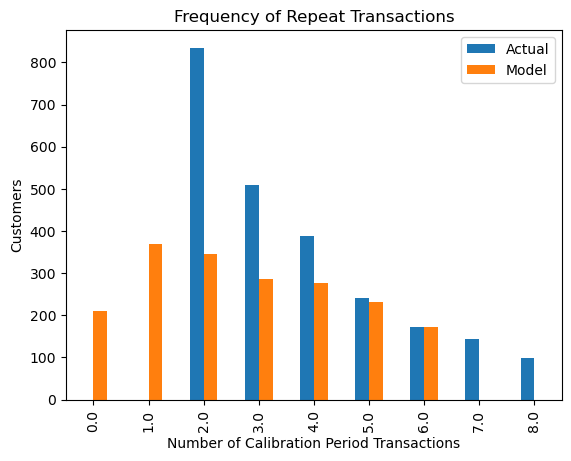

In [12]:
plot_period_transactions(bgf)
plt.show(block=True)

In [13]:
cltv_df["expected_purc_a_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4, cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

cltv_df["expected_purc_3_month"] = bgf.predict(12, cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

cltv_df.head()

,recency,T,frequency,monetary,expected_purc_a_month,expected_purc_3_month
CustomerID,,,,,,
12347.00000000,52.14285714,52.57142857,7,553.92000000,0.56350839,1.67837267
12348.00000000,40.28571429,51.28571429,4,139.39250000,0.36675891,1.09202740
12352.00000000,37.14285714,42.42857143,8,175.11750000,0.72710369,2.16305381
12356.00000000,43.14285714,46.57142857,3,694.49666667,0.34352024,1.02215460
12358.00000000,21.28571429,21.57142857,2,481.87500000,0.48622691,1.43878750


### Gamma-Gamma Model
with this model we are going to calculate expected customer value in a specified time period

In [14]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.82, q: 0.36, v: 3.75>

In [15]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary']) #per puchase
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_a_month,expected_purc_3_month,expected_average_profit
CustomerID,,,,,,,
12347.00000000,52.14285714,52.57142857,7,553.92000000,0.56350839,1.67837267,568.03250729
12348.00000000,40.28571429,51.28571429,4,139.39250000,0.36675891,1.09202740,146.45593275
12352.00000000,37.14285714,42.42857143,8,175.11750000,0.72710369,2.16305381,179.33687873
12356.00000000,43.14285714,46.57142857,3,694.49666667,0.34352024,1.02215460,736.84023650
12358.00000000,21.28571429,21.57142857,2,481.87500000,0.48622691,1.43878750,527.91254776


### Customer Lifetime Value for 3 months

In [16]:
cltv_df["cltv"] = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,
                                   freq="W",  # Frequency period ("Weeks")
                                   discount_rate=0.01)
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_a_month,expected_purc_3_month,expected_average_profit,cltv
CustomerID,,,,,,,,
12347.00000000,52.14285714,52.57142857,7,553.92000000,0.56350839,1.67837267,568.03250729,1014.37328141
12348.00000000,40.28571429,51.28571429,4,139.39250000,0.36675891,1.09202740,146.45593275,170.16162581
12352.00000000,37.14285714,42.42857143,8,175.11750000,0.72710369,2.16305381,179.33687873,412.68251911
12356.00000000,43.14285714,46.57142857,3,694.49666667,0.34352024,1.02215460,736.84023650,801.27042554
12358.00000000,21.28571429,21.57142857,2,481.87500000,0.48622691,1.43878750,527.91254776,807.59122892


In [17]:
cltv_df["segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df.sort_values("cltv", ascending = False).head(20)

,recency,T,frequency,monetary,expected_purc_a_month,expected_purc_3_month,expected_average_profit,cltv,segment
CustomerID,,,,,,,,,
14096.00000000,13.85714286,14.57142857,17,2740.07000000,2.89554070,8.55264875,2767.52790047,25162.07341297,A
14911.00000000,53.14285714,53.42857143,201,565.68706468,12.47219759,37.16410950,566.17700053,22388.95045129,A
14646.00000000,50.42857143,50.71428571,73,1194.81479452,4.81191515,14.33398549,1197.61098757,18265.25792386,A
14088.00000000,44.57142857,46.14285714,13,2959.56692308,1.03790793,3.08956190,2998.44530875,9856.02047541,A
14156.00000000,51.57142857,53.14285714,55,879.42490909,3.50047757,10.42981493,882.17667081,9790.08439429,A
13089.00000000,52.28571429,52.85714286,97,500.08206186,6.13302982,18.27358041,500.98484362,9740.97480821,A
18102.00000000,52.28571429,52.57142857,60,709.65183333,3.86359860,11.51115732,711.69890538,8717.00028978,A
17511.00000000,52.85714286,53.42857143,31,1318.46129032,2.02975910,6.04764949,1325.73738298,8530.95344685,A
12415.00000000,44.71428571,48.28571429,21,1755.95285714,1.51389524,4.50797458,1770.23512497,8490.57929637,A


In [18]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.00000000,28.41506402,16.26670871,0.00000000,14.00000000,29.57142857,42.71428571,53.28571429
T,2845.00000000,36.96916897,14.71298879,0.42857143,27.42857143,40.42857143,51.28571429,53.42857143
frequency,2845.00000000,5.98910369,9.04424704,2.00000000,2.00000000,4.00000000,6.00000000,209.00000000
monetary,2845.00000000,307.03418452,233.74700358,3.30750000,167.65000000,256.97000000,376.93857143,2959.56692308
expected_purc_a_month,2845.00000000,0.62456713,0.59224199,0.00000000,0.33612553,0.50950199,0.75699486,12.96333999
expected_purc_3_month,2845.00000000,1.85276360,1.76071315,0.00000000,0.99918670,1.51150308,2.24499763,38.62761980
expected_average_profit,2845.00000000,323.64711285,245.45333342,4.43037179,177.95737082,270.34025709,394.32133301,2998.44530875
cltv,2845.00000000,659.87769555,1025.71219678,0.00000000,228.31216701,444.50007199,807.17598702,25162.07341297


In [19]:
cltv_df.groupby("segment").agg({"count", "mean", "sum"}).sort_values("segment",ascending = False)

recency                                T                            frequency                   monetary                              expected_purc_a_month                         expected_purc_3_month                          expected_average_profit                               cltv                               
          count            sum        mean count            sum        mean     count   sum        mean    count             sum         mean                 count          sum       mean                 count           sum       mean                   count             sum         mean count              sum          mean
segment                                                                                                                                                                                                                                                                                                                             
A           711 22215.42857143 31.24532851   711 24360.28571429 34.26200522       711  7946 11.17580872      711 367772.91270939 517.26148060                   711 767.70239420 1.07975020                   711 2277.33548495 3.20300350                     711 382900.32458586 538.53772797   711 1128308.71251618 1586.93208511
B           711 21439.00000000 30.15330520   711 25079.28571429 35.27325698       711  4021  5.65541491      711 225524.91999949 317.19398031                   711 467.75919654 0.65788917                   711 1386.89297716 1.95062303                     711 237069.04927363 333.43044905   711  429058.11073666  603.45725842
C           711 21444.14285714 30.16053848   711 26815.85714286 37.71569218       711  2832  3.98312236      711 172114.74991464 242.07419116                   711 337.84905129 0.47517447                   711 1002.50678253 1.40999547                     711 183830.24483844 258.55168050   711  234962.26007586  330.46731375
D           712 15742.28571429 22.10995185   712 28921.85714286 40.62058587       712  2240  3.14606742      712 108099.67232854 151.82538248                   712 203.58283118 0.28593094                   712  604.37718919 0.84884437                     712 116976.41734667 164.29272099   712   85022.96050915  119.41427038

# Conclusion
In conclusion, the CLTV (Customer Lifetime Value) method is a powerful tool for businesses to analyze customer behavior and make informed decisions about marketing strategies. In this Kaggle notebook, we explored how to calculate CLTV using the BG-NBD and Gamma-Gamma models.

By analyzing customer transaction data and applying these models, we were able to predict the expected future value of each customer and segment them accordingly. This allowed us to identify which customers are the most valuable to the business and how to tailor marketing strategies to maximize their value.

Overall, the CLTV method provides businesses with a deeper understanding of their customer base and helps to optimize marketing efforts. As data science continues to evolve, I believe that CLTV will become an increasingly valuable tool for businesses looking to stay ahead in a competitive market.

Thank you for your suggestions and comments :)  
My linkedin profile: https://www.linkedin.com/in/sefercan-apaydin/  
My Github profile: https://github.com/sefercanapaydin  
References: https://www.miuul.com/